# Прогноз оттока пользователей в фитнес-центрах

# Описание проекта

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Ваша задача — провести анализ и подготовить план действий по удержанию клиентов:
 
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента; - сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства; 
- проанализировать основные признаки, наиболее сильно влияющие на отток; 
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

1. Выделить целевые группы клиентов 
2. Предложить меры по снижению оттока 
3. Определить другие особенности взаимодействия с клиентами.

**Описание данных**

'Churn' — факт оттока в текущем месяце;

Текущие поля в датасете:

Данные клиента за предыдущий до проверки факта оттока месяц:

- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

## Загрузим данные

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

#доп настройки
pd.options.display.expand_frame_repr = False
import warnings
warnings.filterwarnings('ignore')

In [2]:
# открываем файл
try:
    df= pd.read_csv('/datasets/gym_churn.csv')
except:
    df= pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn.csv')
    
#для удобства отобразим все колонки таблицы, округлим числовые значения до сотых и задаим формат будущих визуализаций
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
sns.set(rc={'figure.figsize':(16,9)})

#ознакомимся с первыми строками таблицы
df.head(3) 

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0


In [4]:
#поменяем порядок столбцов, чтобы бинарные признаки были рядом, а затем шли небинарные (кроме churn)
df = df[['gender',
         'near_location',
         'partner',
         'promo_friends',
         'phone',
         'group_visits',
         'age',
         'contract_period',
         'month_to_end_contract',
         'lifetime',
         'avg_class_frequency_total',
         'avg_class_frequency_current_month',
         'avg_additional_charges_total',
         'churn']]

<div class="alert alert-block alert-info">
<b>Совет🤔: </b> 

Согласен - довольно удобный вид признаков поможет нам в дальнейешм более удобно записывать признаки в наших функциях либо методах. За соблюдение PEP-8 лайк)
    
Переименовывать колонки в таком случае лучше не через атрибут columns, а через специальный метод pandas.DataFrame.rename с аргументом в виде словаря, ведь тогда мы чётко зададим соответствие исходного и нового названия колонки, а сейчас мы неявно привязаны к нумерации столбцов. Если в DataFrame поменяется порядок столбцов, то такая ячейка отработает уже некорректно, плюс есть риск перепутать порядок при вводе и ошибиться
</div>


In [5]:
#посмотрим поизвольный семпл из таблицы
df.sample(10)

,gender,near_location,partner,promo_friends,phone,group_visits,age,contract_period,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,avg_additional_charges_total,churn
567,1,1,0,0,1,0,33,1,1.00,6,2.37,2.32,160.06,0
2721,1,1,0,0,1,1,24,1,1.00,1,1.17,1.16,111.86,1
547,0,1,0,0,1,0,28,1,1.00,1,0.12,0.00,246.50,1
3547,0,1,1,1,1,1,33,12,11.00,9,2.62,2.68,271.00,0
2049,0,1,1,1,1,1,30,12,12.00,9,0.00,0.01,102.70,0
2226,1,1,1,0,1,0,27,6,5.00,2,0.48,0.34,180.68,0
1910,1,1,0,0,0,0,28,1,1.00,0,1.80,1.87,101.83,1
1519,1,1,1,1,1,1,33,12,12.00,7,1.73,1.83,265.36,0
737,0,1,1,0,0,1,32,1,1.00,7,2.31,2.38,89.95,0
3266,0,1,0,0,1,0,32,1,1.00,6,2.84,2.75,66.05,0


In [6]:
#посмотрим на общие сведения о таблице
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   group_visits                       4000 non-null   int64  
 6   age                                4000 non-null   int64  
 7   contract_period                    4000 non-null   int64  
 8   month_to_end_contract              4000 non-null   float64
 9   lifetime                           4000 non-null   int64  
 10  avg_class_frequency_total          4000 non-null   float64
 11  avg_class_frequency_current_month  4000 non-null   float

(4000, 14)

In [7]:
#посмотрим на уникальные значения в столбце с месяцами
df['month_to_end_contract'].value_counts()

1.00     2207
6.00      645
12.00     524
11.00     181
5.00      130
10.00      82
9.00       73
4.00       58
8.00       38
7.00       25
3.00       23
2.00       14
Name: month_to_end_contract, dtype: int64

In [8]:
#переведем тип данных в целочисленный
df.month_to_end_contract = df.month_to_end_contract.astype(np.int64)

In [9]:
#проверим датасет на дубликаты
df.duplicated().sum()

0

**Вывод**

У нас имеется исходная информация о данных пользователя за предыдущий до проверки факта оттока месяц, информация на основе журнала посещений, покупок, а также информация о текущем статусе абонемента клиента.

Данные представлены в виде таблицы из 4 000 строк и 14 столбцов с полом, фактом проживания или работы в районе фитнес-центра, выделением сотрудников компании-партнёра клуба, фактом первоначальной записи в рамках акции «приведи друга», обозначением наличия контактного телефона, возрастом, временем с момента первого обращения в фитнес-центр, длительностью текущего действующего абонемента, сроком до окончания текущего действующего абонемента, фактом посещения групповых занятий, средняя частотой посещений в неделю за все время с начала действия абонемента и за предыдущий месяц, суммарной выручкой от других услуг фитнес-центра, фактом оттока в текущем месяце.

На этапе подготовки данных названия столбцов в таблице были приведены к нижнему регистру, был изменен тип данных столбца с информацией о сроке до окончания текущего действующего абонемента. Пропусков и дубликатов в данных нет.

## Проведём исследовательский анализ данных (EDA)

### Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,"4,000.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,"4,000.00",0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,"4,000.00",0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,"4,000.00",0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,"4,000.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
group_visits,"4,000.00",0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,"4,000.00",29.18,3.26,18.00,27.00,29.00,31.00,41.00
contract_period,"4,000.00",4.68,4.55,1.00,1.00,1.00,6.00,12.00
month_to_end_contract,"4,000.00",4.32,4.19,1.00,1.00,1.00,6.00,12.00
lifetime,"4,000.00",3.72,3.75,0.00,1.00,3.00,5.00,31.00


Большая часть клиентов живет рядом с фитнес-клубами, об этом говорит высокое среднее и низкое стандартное отклонение. Значит, разброс небольшой. 

Половина клиентов пришла по партнерским программам. Мало тех, кто пришел по акции "приведи друга", почти у всех указан номер телефона, менее половины посещают групповые занятия, видимо предпочитая заниматься самостоятельно. 

Средний возраст клиента 29-30 лет. Абонементы бывают от 1 до 12 месяцев и судя по стандартному отклонению разброс этих абонементов большой. Это касается и срока окончания действия абонементов. 

Есть клиенты, которые еще ни разу не посетили занятия и те, кто занимается более 2 лет. Есть фанаты, которые занимаются по 6 раз в неделю, но в среднем это 1-2 посещения в неделю. 

Максимальная выручка с допуслуг в центрах более 500 единиц валюты, в среднем 147. Отток на первый взгляд выглядит не серьёзным, в среднем около 30%. Но это и не мало. Почему так происходит, выясним далее.

**Изучим данные по каждому столбцу**

**Пол**

In [11]:
df['gender'].describe()

count   4,000.00
mean        0.51
std         0.50
min         0.00
25%         0.00
50%         1.00
75%         1.00
max         1.00
Name: gender, dtype: float64

In [12]:
df['gender'].unique()

array([1, 0])

У нас есть данные о мужчинах и женщинах, которые обозначаются 0 и 1. При этом, в выборке их равное количество. Так как выборка имеет чётное число данных, средняя близка к 0,5, а медианное значение равно 1.

**Близость к району с фитнес-центром**

In [13]:
df['near_location'].describe()

count   4,000.00
mean        0.85
std         0.36
min         0.00
25%         1.00
50%         1.00
75%         1.00
max         1.00
Name: near_location, dtype: float64

In [14]:
df['near_location'].unique()

array([1, 0])

У нас имеются данные о людях, которые живут/работают рядом с фитнес-центром, либо далеко от него. Категории обозначаются 0 и 1. При этом в выборке больше тех, кто живёт или работает рядом, так как средняя близка к 0,85, а первый квартиль равен 1.

**Сотрудник компании-партнёра клуба**

In [15]:
df['partner'].describe()

count   4,000.00
mean        0.49
std         0.50
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: partner, dtype: float64

In [16]:
df['partner'].unique()

array([1, 0])

Данные о людях, которые являются или не являются сотрудниками компании-партнёра клуба, обозначаются 0 и 1. При этом в выборке примерно в равной пропорции представлены обе группы (средняя близка к 0,5).

**Первый абонемент по акции "Приведи друга"**

In [17]:
df['promo_friends'].describe()

count   4,000.00
mean        0.31
std         0.46
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: promo_friends, dtype: float64

In [18]:
df['promo_friends'].unique()

array([1, 0])

У нас имеются данные о людях, которые приобрели или не приобрели первый абонемент по акции "Приведи друга". Категории обозначаются 0 и 1. При этом в выборке больше тех, кто не пришёл по данной акции (так как средняя близка к 0,3, а медиана равна 0).

**Наличие контактного телефона**

In [19]:
df['phone'].describe()

count   4,000.00
mean        0.90
std         0.30
min         0.00
25%         1.00
50%         1.00
75%         1.00
max         1.00
Name: phone, dtype: float64

In [20]:
df['phone'].unique()

array([0, 1])

В имеющихся данных по клиентам либо есть данные о контактном телефоне (значение 1), либо их нет (значение 0). При этом в выборке больше тех, для кго представлена контактная информация (так как средняя близка к 0,9, а четвёртый квартиль равен 1).

**Возраст**

In [21]:
df['age'].describe()

count   4,000.00
mean       29.18
std         3.26
min        18.00
25%        27.00
50%        29.00
75%        31.00
max        41.00
Name: age, dtype: float64

In [22]:
df['age'].sort_values().unique()

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 41])

У нас имеются данные о клиентах возрастом от 18 до 41 года (при этом нет клиентов в возрасте 40 лет). Средний возраст равен 29 годам. При этом люди разного возраста выбраны достаточно равномерно (так как средняя близка к медиане, а стандартное отклонение очень низкое).

**Время с момента первого обращения**

In [23]:
df['lifetime'].describe()

count   4,000.00
mean        3.72
std         3.75
min         0.00
25%         1.00
50%         3.00
75%         5.00
max        31.00
Name: lifetime, dtype: float64

In [24]:
df['lifetime'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 31])

У нас имеются данные о клиентах, которые обращались в фитнес-центр впервые от 0 до 31 месяца назад. При этом нет клиентов, у которых прошло 25, 28 или 30 месяцев с момента первого обращения. Среднее время с момента первого обращения составляет 3 месяца. При этом есть небольшой перекос в данных, так как среднее значение ближе к 4 месяцам.

**Длительность действующего абонемента**

In [25]:
df['contract_period'].describe()

count   4,000.00
mean        4.68
std         4.55
min         1.00
25%         1.00
50%         1.00
75%         6.00
max        12.00
Name: contract_period, dtype: float64

In [26]:
df['contract_period'].sort_values().unique()

array([ 1,  6, 12])

Действующий абонемент по рассматриваемым клиентам имеет срок в 1, 6 и 12 месяцев. В выборку не попали клиенты, у которых срок составляет 3 месяца. Средняя длительность действующего абонемента составляет 4-5 месяцев. При этом есть перекос в данных: для большинства срок действующего абонемента равен 1 месяц.

**Срок до окончания действующего абонемента**

In [27]:
df['month_to_end_contract'].describe()

count   4,000.00
mean        4.32
std         4.19
min         1.00
25%         1.00
50%         1.00
75%         6.00
max        12.00
Name: month_to_end_contract, dtype: float64

In [28]:
df['month_to_end_contract'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

**Посещение групповых занятий**

In [29]:
df['group_visits'].describe()

count   4,000.00
mean        0.41
std         0.49
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: group_visits, dtype: float64

In [30]:
df['group_visits'].unique()

array([1, 0])

У нас есть данные о клиентах, которые посещают групповые занятия (значение 1) или не посещают (значение 0). При этом в выборке чуть больше тех, кто не посещает такие занятия (средняя близка к 0,4, а медиана равна 0).

**Средняя частота посещений в неделю за все время**

In [31]:
df['avg_class_frequency_total'].describe()

count   4,000.00
mean        1.88
std         0.97
min         0.00
25%         1.18
50%         1.83
75%         2.54
max         6.02
Name: avg_class_frequency_total, dtype: float64

У нас имеются данные по клиентам со средней частотой посещений за все время с начала действия абонемента от 0 до 6 раз в неделю. В среднем это значение - около 2 раз в неделю. При этом, выборка равномерная, так как среднее почти равно медиане, а стандартное отклонение невысоко.

**Средняя частота посещений в неделю за предыдущий месяц**

In [32]:
df['avg_class_frequency_current_month'].describe()

count   4,000.00
mean        1.77
std         1.05
min         0.00
25%         0.96
50%         1.72
75%         2.51
max         6.15
Name: avg_class_frequency_current_month, dtype: float64

У нас имеются данные по клиентам со средней частотой посещений за месяц от 0 до 6 раз в неделю. В среднем это значение составляет около 2 раз в неделю. Выборка равномерная, так как среднее почти равно медиане, а стандартное отклонение невысоко.

**Выручка от других услуг фитнес-центра**

In [33]:
df['avg_additional_charges_total'].describe()

count   4,000.00
mean      146.94
std        96.36
min         0.15
25%        68.87
50%       136.22
75%       210.95
max       552.59
Name: avg_additional_charges_total, dtype: float64

Выручка от прочих услуг фитнес-центра составила от 0,15 до 552,6 ден.ед. В среднем это значение составляет около 147 ден.ед., медиана равна 136 ден.ед. Разброс данных очень большой. Мы не знаем, в каких ден.ед. измеряются данные.

**Отток в текущем месяце**

In [34]:
df['churn'].describe()

count   4,000.00
mean        0.27
std         0.44
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: churn, dtype: float64

У нас есть данные о клиентах, которые продолжают пользоваться услугами фитнес-центра (значение 0) и тех, кто ушёл (значение 1). При этом в выборке больше тех, кто продолжает пользоваться услугами (средняя близка к 0,3, а медиана равна 0).

### Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [35]:
#Изучим средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
df.groupby('churn').agg('mean').T

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
group_visits,0.46,0.27
age,29.98,26.99
contract_period,5.75,1.73
month_to_end_contract,5.28,1.66
lifetime,4.71,0.99


Если среднее значение по бинарным показателям (0 и 1) ближе к 1, значит людей с признаком больше, чем без него. Если меньше 0,5, значит их меньше.

По полу примерно равное количество человек разного пола в двух группах.

В лояльной группе больше тех, кто живёт или работает рядом.

Есть различия в оттоке между сотрудниками компании-партнёра клуба. Из тех, кто остался большая часть связаны с партнёрами. Из тех, кто ушёл в отток - не связаны с компанией-партнёром.

В обеих группах больше людей, которые приобрели первый абонемент не по промо-акции "Приведи друга". Но среди тех, кто остался, пришедших по промо-акции больше.

Нет различий между группами в наличии контактного телефона клиентов - практически все оставляют контакты для связи.

Длительность действующего абонемента по оставшимся пользователям в среднем 5-6 месяцев, а по ушедшим - 1-2 месяца. Это говорит о том, что купившие длительный абонемент реже идут в отток, чем те, у кого он на короткий срок.

Посещение групповых занятий по выделенным группам также отличается: среди оставшихся клиентов распределение примерно равномерно. Среди тех, кто ушёл в отток, непосещающих групповые занятия значительно больше.

В группе лояльных фитнес-центру людей средний возраст составляет около 30 лет, а среди уходящих - около 27 лет. То есть вторая группа моложе.

Средняя выручка от других услуг фитнес-центра между группами разнится на 43 ден.ед. В группе лояльных она выше, чем в группе уходящих.

В среднем срок до окончания действующего абонемента у людей, ушедших в отток около 1-2 месяцев, а у оставшихся клиентов - около 5 месяцев. Это снова указывает на то, что уходят в большей степени те, у кого длительность оставшегося абонемента невысока.

Время с момента первого обращения для уходящих в отток равно 1 месяцу, а для тех, кто остался, близко к 5 месяцам. Таким образом, лояльные первые месяцы клиенты, скорее всего, не уйдут в отток после длительного периода пользования услугами фитнес-центра.

Средняя частота посещений в неделю за время действия абонемента в группах не сильно отличается. Лояльные клиенты в среднем посещают центр 2 раза в неделю, а ушедшие - от 1 до 2.

Разница между группами в средней частоте посещений в неделю за месяц также не сильно высока: не ушедшие в отток клиенты в среднем посещали фитнес-клуб 2 раза в неделю, а ушедшие в отток - 1 раз в неделю.

### Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл и тех, кто остался  

In [36]:
# Разделим выборки на клиентов, ушедших в отток (churn_clients), и клиентов, которые остались (loyal_clients)
churn_clients = df.query('churn == 1')
loyal_clients = df.query('churn == 0')

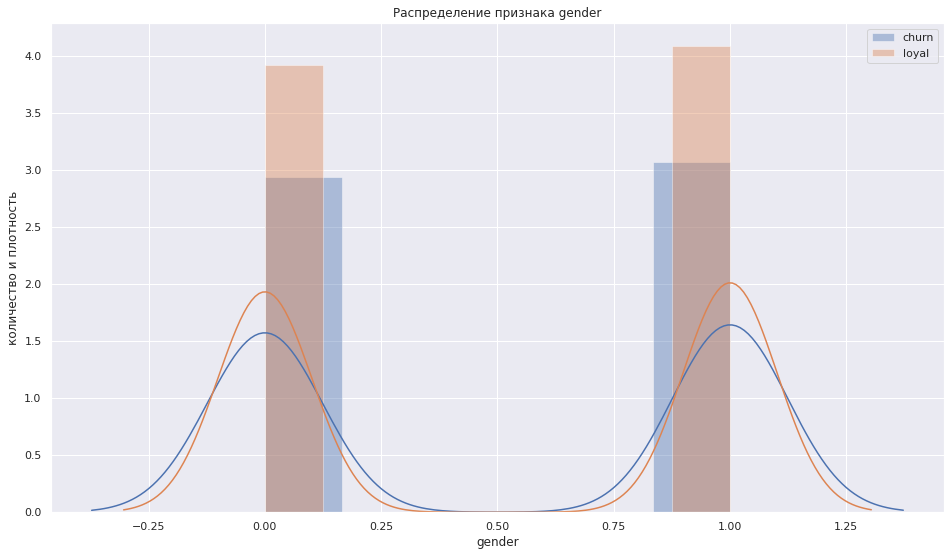

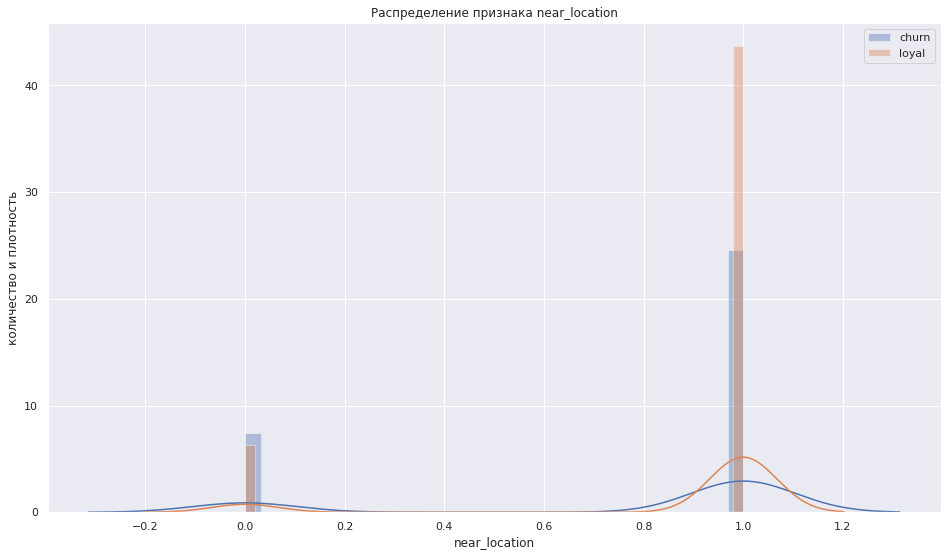

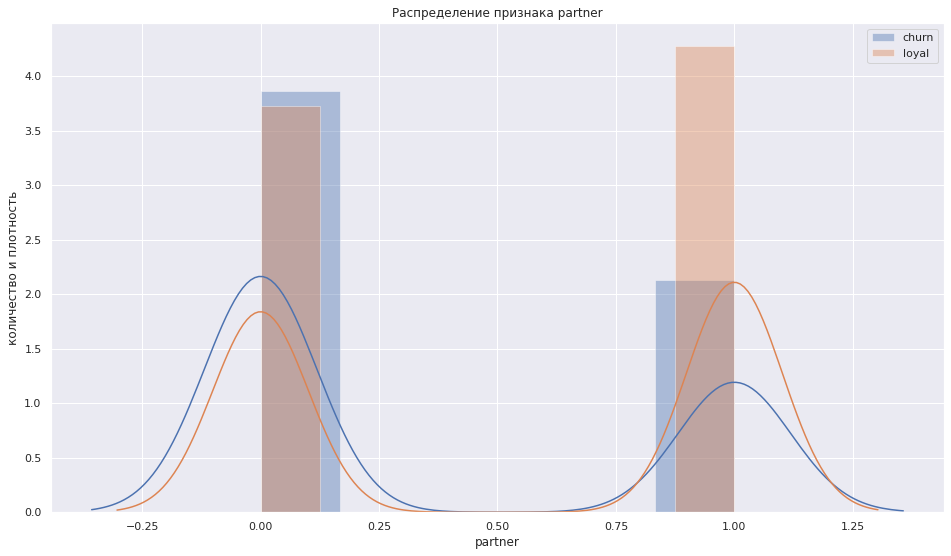

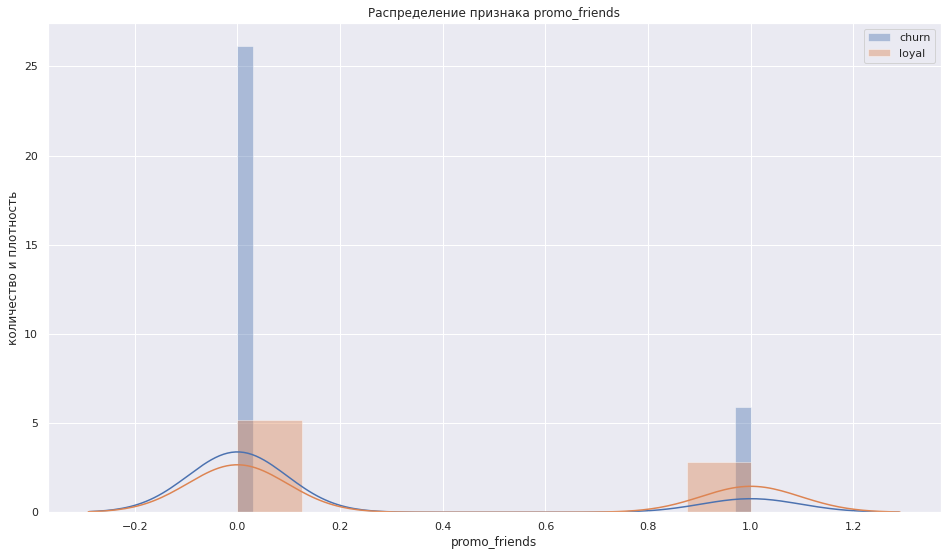

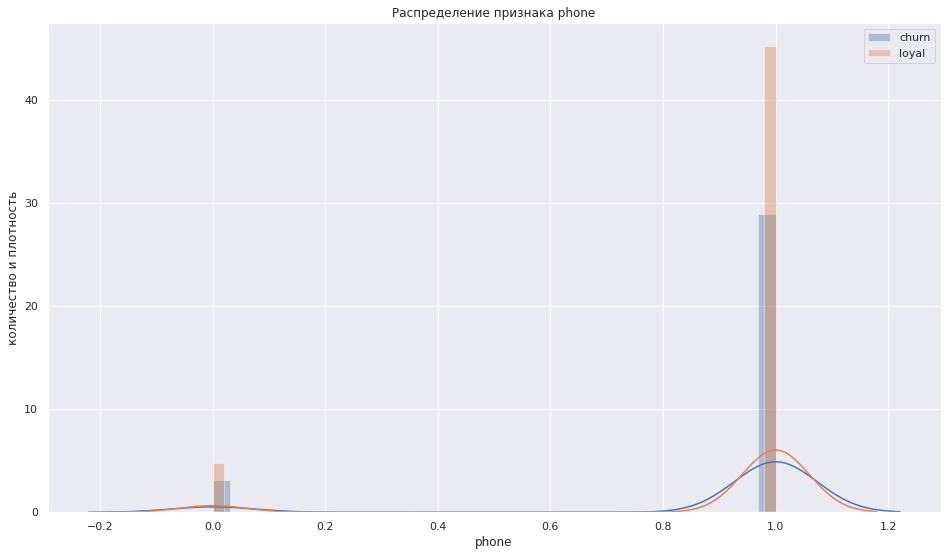

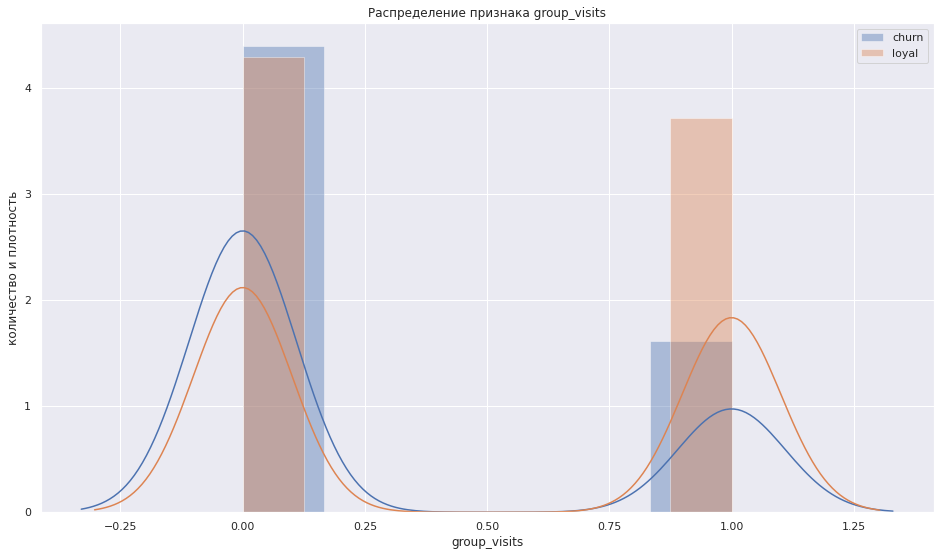

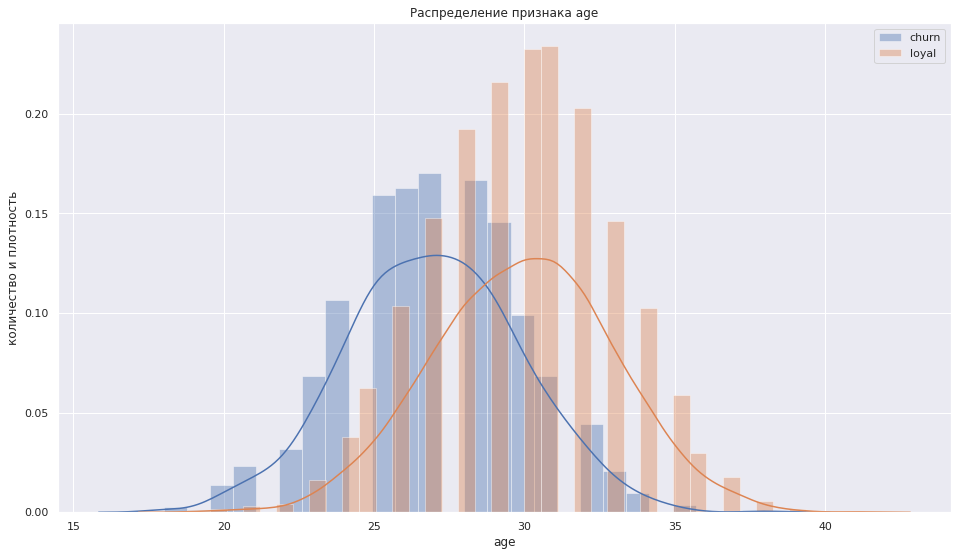

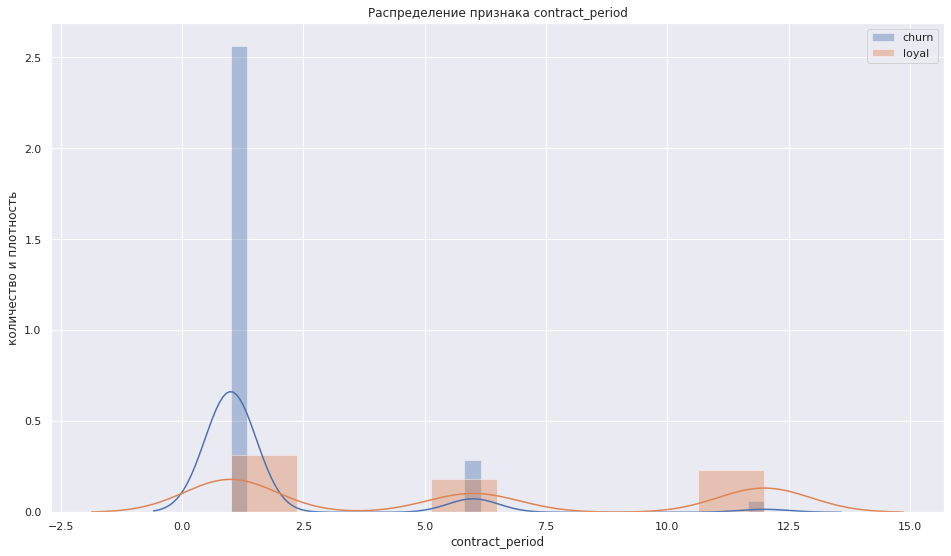

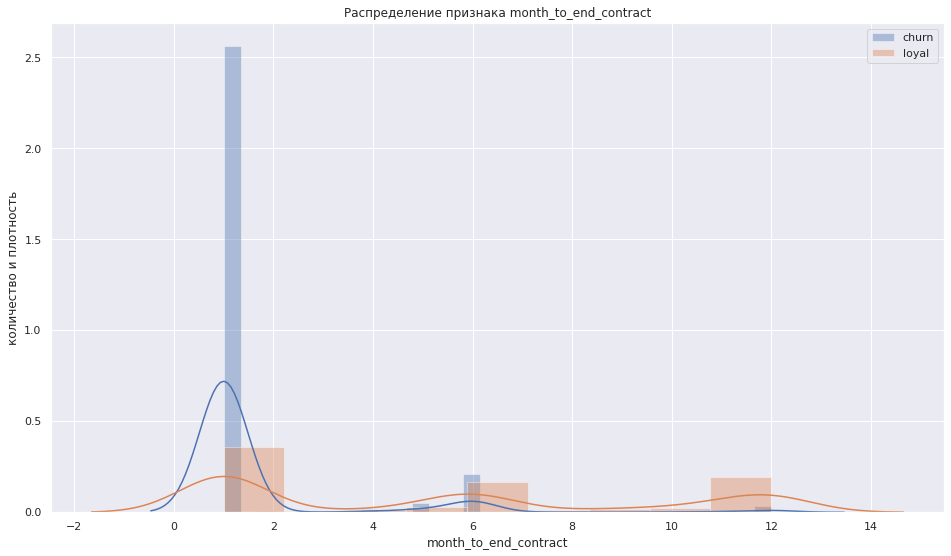

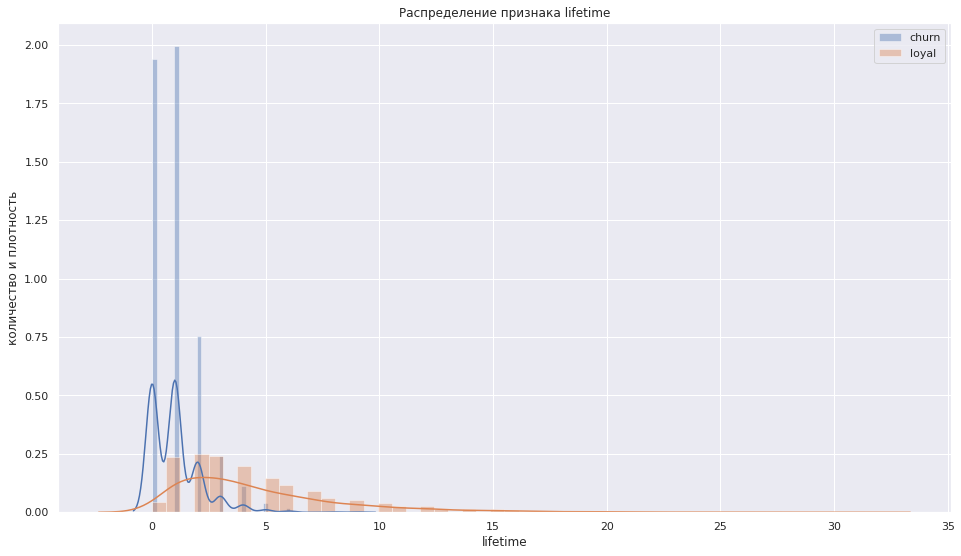

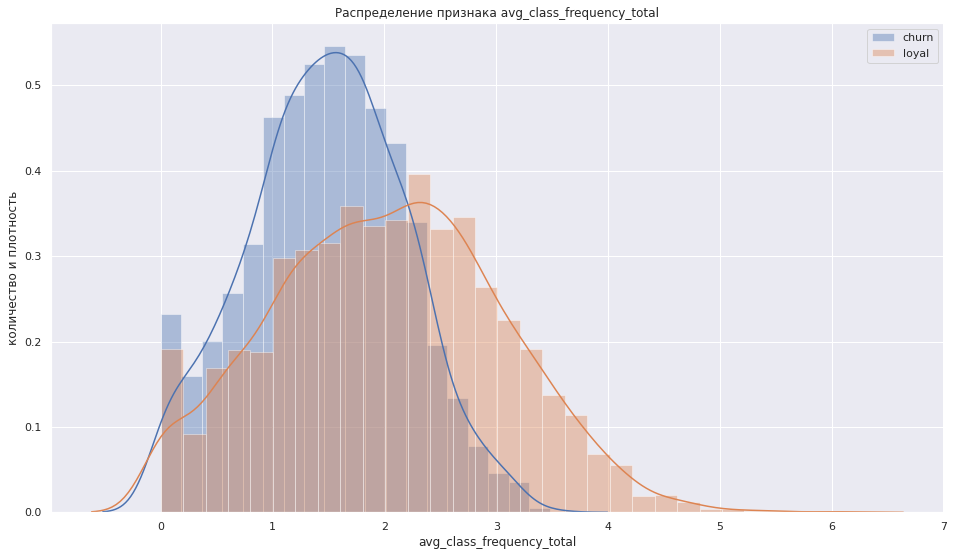

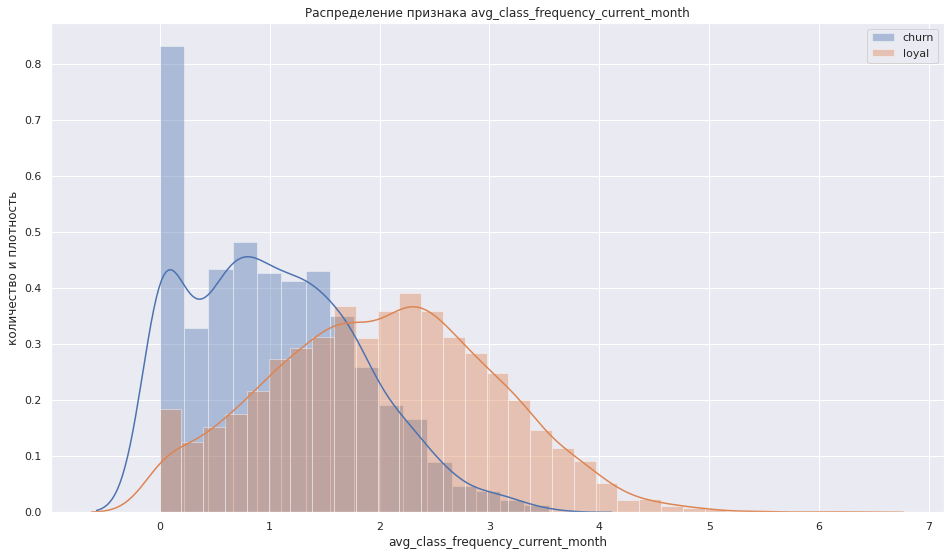

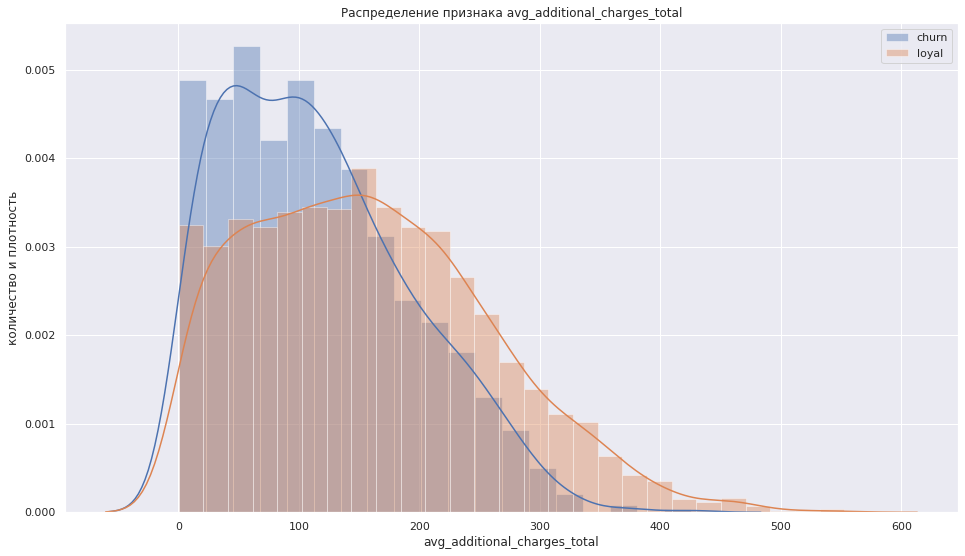

In [37]:
#Построим столбчатые гистограммы и распределения признаков для обоих групп
fig, ax = plt.subplots()
for column in df.drop('churn', axis = 1).columns:
    plt.title("Распределение признака "+column)
    plt.xlabel(column)
    plt.ylabel("количество и плотность")
    sns.distplot(churn_clients[column], label='churn')
    sns.distplot(loyal_clients[column], label='loyal')
    plt.legend()
    plt.show()

**Вывод**

По полу, близости к фитнес-центру, наличию контактного телефона обе группы имеют схожее равномерное распределение.

Есть различия в распределении групп между теми, кто является сотрудником компании-партнёра клуба и не является. В группе лояльных клиентов число имеющих отношение к компании-партнёра сотрудников явно больше, чем среди тех, кто уходит в отток. Различия в распределении групп по посещению групповых занятий такие же, как и в распределениях по принадлежности к компании-партнёру.

Среди тех, кто остался, по промо-акции "Приведи друга" клиентов немного больше, но распределения схожи.

Распределение длительности действующего абонемента по оставшимся пользователям и ушедшим различается. Лояльных клиентов, приобретающих абонемент на 1 месяц больше всего. Меньше их сроком на год, и наименьшее количество клиентов - на 6 месяцев. А для ушедших в отток 1 месяц - самый популярный, затем - 6 месяцев (с очень низким числом абонементов), и практически нет абонементов на 12 месяцев. Различия в распределении групп по сроку до окончания действующего абонемента такие же, как и в распределениях по длительности абонемента.

По среднему возрасту обе группы имеют нормальное распределение, но датасет лояльных клиентов смещён вправо, а датасет ушедших клиентов - влево.

Распределение средней выручки от других услуг фитнес-центра двух датасетов смещено влево с большим смещением для ушедших людей. То есть те, кто уходит, почти не тратят на дополнительные услуги в фитнес-центре.

Распределение времени с момента первого обращения для обоих групп похоже на распределение Пуассона. Но для ушедших в отток клиентов оно сильно смещено влево, практически не имея значения в более высоких значениях, а для лояльных клиентов принимает более высокие значения.

Распределение для средней частоты посещений в неделю за время действия абонемента в обоих группах  нормальное. Для лояльной группы оно немного смещено влево, а для группы уходящих в отток есть сильное смещение влево. Аналогичные различия между группами наблюдаются и для распределений средней частоты посещений в неделю за месяц.

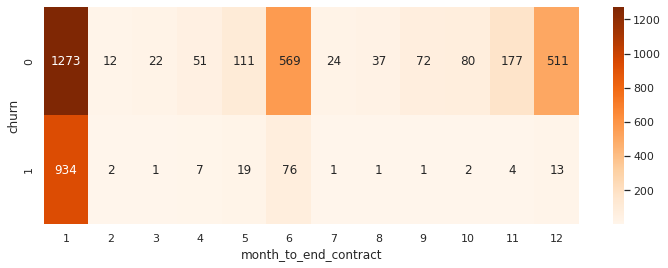

In [41]:
viz_data = df\
    .pivot_table(
        index='churn',
        columns='month_to_end_contract',
        values='age',
        aggfunc='count'
    )
plt.figure(figsize=(12, 4))
sns.heatmap(viz_data, cmap='Oranges', annot=True, fmt='.0f')
plt.show()

### Построим матрицу корреляций  

In [42]:
correlation = df.corr()
correlation.T

,gender,near_location,partner,promo_friends,phone,group_visits,age,contract_period,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,avg_additional_charges_total,churn
gender,1.00,0.01,-0.01,-0.01,-0.01,0.02,0.01,0.00,-0.00,0.01,0.01,0.01,-0.01,0.00
near_location,0.01,1.00,-0.01,0.21,-0.02,0.15,0.06,0.15,0.14,0.07,0.04,0.06,0.04,-0.13
partner,-0.01,-0.01,1.00,0.45,0.01,0.02,0.05,0.31,0.29,0.06,0.02,0.05,0.02,-0.16
promo_friends,-0.01,0.21,0.45,1.00,0.00,0.12,0.05,0.24,0.24,0.07,0.03,0.05,0.04,-0.16
phone,-0.01,-0.02,0.01,0.00,1.00,-0.01,-0.01,-0.01,-0.01,-0.02,0.01,0.01,0.01,-0.00
group_visits,0.02,0.15,0.02,0.12,-0.01,1.00,0.08,0.17,0.16,0.08,0.06,0.08,0.03,-0.18
age,0.01,0.06,0.05,0.05,-0.01,0.08,1.00,0.14,0.13,0.16,0.12,0.18,0.08,-0.40
contract_period,0.00,0.15,0.31,0.24,-0.01,0.17,0.14,1.00,0.97,0.17,0.10,0.16,0.11,-0.39
month_to_end_contract,-0.00,0.14,0.29,0.24,-0.01,0.16,0.13,0.97,1.00,0.16,0.09,0.15,0.11,-0.38
lifetime,0.01,0.07,0.06,0.07,-0.02,0.08,0.16,0.17,0.16,1.00,0.11,0.18,0.08,-0.44


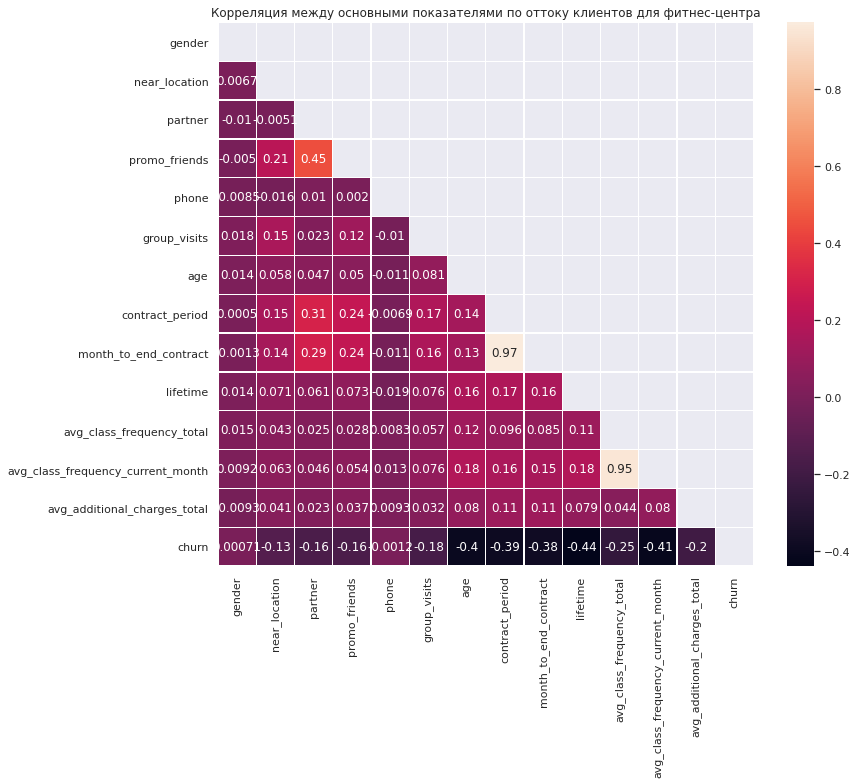

In [43]:
fig, ax = plt.subplots(figsize=(12,10))
plt.title("Корреляция между основными показателями по оттоку клиентов для фитнес-центра")
mask = np.triu(np.ones_like(correlation, dtype=np.bool))
sns.heatmap(correlation, linewidths=.3, annot=True, mask=mask, ax=ax)
ax.set_ylim(14, 0);

**Вывод**

По матрице корреляции видим, что такие признаки как пол и наличие контактного телефона не влияют на конечный показатель оттока. Все остальные показатели имеют обратное влияние: слабое, либо чуть более сильное. Явно влияющих признаков, сильно связанных с результирующим показателем, предварительный анализ не выделил.


Отметим, что имеется сильная связь между показателями длительности абонемента и количеством месяцев до конца абонемента. Это говорит о том, что в выборке представлены клиенты, которые отобраны на определённом этапе покупки абонемента. Скорее всего, в начале действия абонемента. 


Также наблюдается сильная связь между средней частотой посещений в неделю с начала пользования услугами и за предыдущий месяц. Это говорит о другой зависимости - клиенты посещают фитнес-центр примерно одинаковое число раз в неделю вне зависимости от того, сколько они пользуются услугами центра.

In [44]:
#Чтобы эти признаки не искажали обучение, удалим их из модели  
df = df.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)

**Вывод**

Исследовательский анализ данных (EDA) позволил сделать следующие выводы.

Анализ показателей:

**Отток клиентов.** У нас есть данные о клиентах, которые продолжают пользоваться услугами фитнес-центра (лояльные клиенты) и тех, кто "ушёл" (нелояльные клиенты). При этом в выборке больше тех, кто продолжает пользоваться услугами (средняя близка к 0,3, а медиана равна 0).

**Пол клиентов.** У нас имеются данные о мужчинах и женщинах. При этом в выборке их равное количество (средняя близка к 0,5, а медианное значение равно 1). Для уходящих в отток клиентов и остающихся распределения этого признака имеют схожий вид.

**Близость к фитнес-центру.** У нас имеются данные о людях, которые живут или работают рядом с фитнес-центром, либо в отдалённости от него. При этом в выборке больше тех, кто живёт или работает рядом (так как средняя близка к 0,85, а первый квартиль равен 1). А в группе, которая лояльна к фитнес-центру, чуть больше человек, которые живут или работают поблизости, чем тех, кто находится в отдалённости. Однако, распределения по этому признаку для лояльных и нелояльных клиентов не сильно отличаются друг от друга.

**Сотрудники компании-партнёра.** Данные о людях, которые являются или не являются сотрудниками компании-партнёра клуба, представлены в выборке примерно в равной пропорции (средняя близка к 0,5). Есть различия в оттоке между теми, кто является сотрудником компании-партнёра клуба. Среди тех, кто остался примерно половина и тех, кто связан с партнёрами, и тех, кто не связан, с небольшим преобладанием первых. Но из тех, кто ушёл в отток, больше клиентов, не связанных с компанией-партнёром. Это же выражено и в распределении соответствующих данных.

**Промо-акция.** У нас имеются данные о людях, которые приобрели или не приобрели первый абонемент по акции "Приведи друга". При этом в обеих группах больше людей, которые приобрели первый абонемент не по промо-акции "Приведи друга" (так как средняя близка к 0,3, а медиана равна 0). Но среди тех, кто остался, пришедших по промо-акции больше, хотя распределения у лояльных клиентов и ушедших близки.

**Контактный телефон.** В имеющихся данных по клиентам либо есть данные о контактном телефоне, либо их нет. При этом в выборке больше тех, для кого представлена контактная информация (так как средняя близка к 0,9, а четвёртый квартиль равен 1) для обоих категорий: лояльных и нелояльных клиентов (распределения схожи).

**Возраст клиентов.** У нас имеются данные о клиентах возрастом от 18 до 41 года (при этом нет клиентов в возрасте 40 лет). Средний возраст равен 29 годам. При этом люди разного возраста выбраны достаточно равномерно (так как средняя близка к медиане, распределение для лояльных и нелояльных клиентов нормальное, а стандартное отклонение очень низкое). Распределение для лояльных клиентов немного смещено вправо, а для ушедших клиентов - влево. Так, в группе лояльных фитнес-центру людей средний возраст составляет около 30 лет, а среди уходящих - около 27 лет. То есть вторая группа чуть младше.

**Время с первого обращения.** У нас имеются данные о клиентах, которые обращались в фитнес-центр впервые от 0 до 31 месяца назад (при этом нет клиентов, у которых прошло 25, 28 или 30 месяцев с момента первого обращения). Среднее время с момента первого обращения составляет 3 месяца. При этом есть перекос в данных, так как среднее значение ближе к 4 месяцам. Распределение времени с момента первого обращения для обоих групп (лояльных и нелояльных) похоже на распределение Пуассона. Но для ушедших в отток клиентов оно сильно смещено влево, практически не имея значения в более высоких значениях, а для лояльных клиентов принимает более высокие значения. Таким образом, среднее время с момента первого обращения для уходящих в отток составило 1 месяц, а для тех, кто остался, близко к 5 месяцам. Клиенты, проявляющие в первые месяцы лояльность, скорее всего, не уйдут в отток после длительного периода пользования услугами фитнес-центра.

**Длительность абонемента.** Действующий абонемент по рассматриваемым клиентам имеет срок в 1, 6 и 12 месяцев (в выборку не попали клиенты, у которых срок составляет 3 месяца). Средняя длительность действующего абонемента составляет 4-5 месяцев. При этом есть перекос в данных: для большинства срок действующего абонемента равен 1 месяцу. Длительность действующего абонемента по оставшимся пользователям в среднем около 5-6 месяцев, а по ушедшим - 1-2 месяца. Это говорит о том, что купившие длительный абонемент с большей неохотой уйдут в отток, чем те, у кого он действует на короткий срок.

**Время до окончания абонемента.** У нас имеются данные по клиентам, до окончания абонементов которых осталось от 1 до 12 месяцев. В среднем это значение около 4 месяцев. При этом больше половины всей выборки - это люди, до конца абонементов которых остался 1 месяц. Различия в распределении групп (лояльных и нелояльных клиентов) по сроку до окончания действующего абонемента такие же, как и в распределениях по длительности абонемента. В среднем срок до окончания действующего абонемента у людей, ушедших в отток, около 1-2 месяцев, а у оставшихся клиентов - около 5 месяцев. Это снова указывает на то, что уходят в большей степени те, у кого длительность оставшегося абонемента невысока.

**Групповые занятия.** У нас есть данные о клиентах, которые посещают групповые занятия или не посещают. При этом в выборке чуть больше тех, кто не посещает такие занятия (средняя близка к 0,4, а медиана равна 0). При этом среди лояльных клиентов распределение посещающих такие занятия и непосещающих примерно равномерно (вторых чуть больше); но среди тех, кто ушёл в отток, непосещающих групповые занятия значительно больше, чем тех, кто их посещает.

**Частота посещений за весь срок.** У нас имеются данные по клиентам со средней частотой посещений за все время с начала действия абонемента от 0 до 6 раз в неделю. В среднем это значение составляет около 2 раз в неделю. При этом выборка равномерная, так как среднее почти равно медиане, а стандартное отклонение невысоко. Распределение для средней частоты посещений в неделю за время действия абонемента в обоих группах (лояльные и нелояльные клиенты) является нормальным. Для лояльной группы оно немного смещено влево, а для группы уходящих в отток имеется сильное смещение влево. Лояльные клиенты, в среднем, посещают центр 2 раза в неделю, а ушедшие - от 1 до 2.

**Частота посещений за месяц.** У нас имеются данные по клиентам со средней частотой посещений за месяц от 0 до 6 раз в неделю. В среднем это значение составляет около 2 раз в неделю. Распределения и средние значения схожи с распределениями аналогичного показателя за весь срок абонемента.

**Выручка от прочих услуг.** Выручка от прочих услуг фитнес-центра с клиента составила от 0,15 до 552,6 ден.ед. В среднем это значение составляет около 147 ден.ед., медиана равна 136 ден.ед. Разброс данных очень большой (мы не знаем наверняка, в каких ден.ед. измеряются данные). Средняя выручка от других услуг фитнес-центра между группами разнится на 43 ден.ед. (в группе лояльных она выше, чем в группе уходящих). Распределение средней выручки от других услуг фитнес-центра для обоих датасетов смещено влево с большим смещением для ушедших людей. То есть те, кто уходит, стараются минимизировать затраты на дополнительные услуги в фитнес-центре.

**На основе корреляции** мы видим, что такие признаки как пол и наличие контактного телефона почти не влияют на конечный показатель оттока. Все остальные показатели имеют обратное влияние: слабое, либо чуть более сильное. Явно влияющих признаков, тесно связанных с результирующим показателем, предварительный анализ не выявил. Также отметим, что имеется сильная связь между показателями длительности абонемента и количеством месяцев до конца абонемента. Это говорит о том, что в выборке представлены клиенты, которые отобраны на определённом этапе покупки абонемента. Скорее всего, в начале действия абонемента. Также наблюдается сильная связь между средней частотой посщений в неделю с началап пользования услугами и за предыдущий месяц. Это говорит о другой зависимости: скорее всего, клиенты посещают фитнес-центр примерно одинаковое число раз в неделю вне зависимости от того, сколько они пользуются услугами центра.

## Построим модель прогнозирования оттока клиентов

### Выделим обучающую и валидационную выборки

In [45]:
# Разделим данные на признаки (матрица x) и целевую переменную (y)
x = df.drop('churn', axis = 1)
y = df['churn']

# Разделим выборку на обучающую и валидационную в соотношении 80:20
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

# Cтандартизируем данные
scaler = StandardScaler()
scaler.fit(x_train)
x_train_st = scaler.transform(x_train)
x_test_st = scaler.transform(x_test)

Мы разделили выборку на обучащую и валидационную в соотношении 80 к 20, то есть на 80% будем обучать модель, а на 20% - проверять.

### Обучение модели

**Логистическая регрессия**

In [46]:
# Зададим алгоритм для модели
logreg_model = LogisticRegression(random_state=0)

# Обучим модель
logreg_model.fit(x_train_st, y_train)

# Воспользуемся обученной моделью, чтобы сделать прогнозы
logreg_predictions = logreg_model.predict(x_test_st)
logreg_probabilities = logreg_model.predict_proba(x_test_st)[:,1]

Построили модель и обучили её алгоритмом логистической регрессии

**Случайный лес**

In [47]:
# Зададим алгоритм для модели
randfor_model = RandomForestClassifier(random_state=0)

# Обучим модель
randfor_model.fit(x_train_st, y_train)

# Воспользуемся обученной моделью, чтобы сделать прогнозы
randfor_predictions = randfor_model.predict(x_test_st)
randfor_probabilities = randfor_model.predict_proba(x_test_st)[:,1]

Построили модель и обучили её алгоритмом случайного леса

### Оценка метрик и сравнение моделей

Создадим функцию для расчёта метрик: accuracy (доля правильных ответов), precision (точность), recall (полнота), F1_score (агрегирующая метрика)

In [48]:
# Определим функцию, которая будет выводить наши метрики
def print_metrics(y_true, y_pred, y_proba, model_name):
    print("Метрики для модели "+model_name)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))    

In [49]:
# Рассчитаем метрики для модели логистической регрессии
print_metrics(y_test, logreg_predictions, logreg_probabilities, 'логистической регрессии')
print()
# Рассчитаем метрики для модели случайного леса
print_metrics(y_test, randfor_predictions, randfor_probabilities, 'случайного леса')

Метрики для модели логистической регрессии
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.84
	F1: 0.84

Метрики для модели случайного леса
	Accuracy: 0.91
	Precision: 0.87
	Recall: 0.80
	F1: 0.83


**Вывод**

При построении модели мы разделили выборку на обучащую и валидационную в соотношении 80 к 20, то есть на 80% данных модель была обучена, а на 20% - проверена. После этого были построены и обучены 2 модели: алгоритмом логистической регрессии и алгоритмом случайного леса.

Основные метрики полученных моделей следующие. Для модели логистической регрессии: Accuracy = 0,92; Precision = 0,85; Recall = 0,84; F1 = 0,84. Для модели случайного леса: Accuracy = 0,91; Precision = 0,87; Recall = 0,80; F1 = 0,83. 

Таким образом, обе модели достаточно хорошо способны делать прогноз. Однако, модель логистической регрессии подходит больше/

## Сделаем кластеризацию клиентов 

Прежде всего, для кластеризации пользователей нам необходимо стандартизировать данные

In [50]:
# Зададим "стандартизатор"
scaler = StandardScaler()

# Стандартизируем данные
x_st = scaler.fit_transform(x)

### Построение матрицы расстояний и дендрограммы

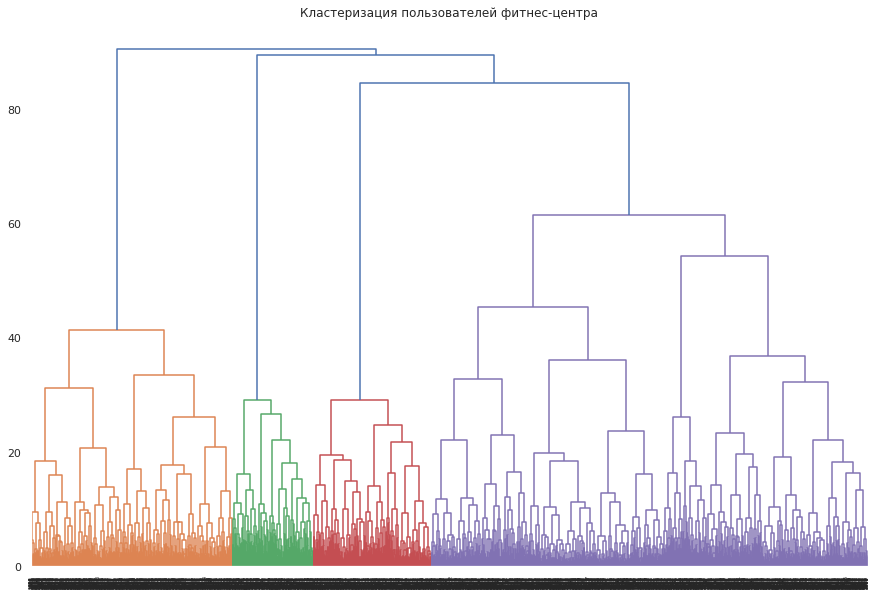

In [51]:
# Сохраним матрицу расстояний
links = linkage(x_st, method = 'ward')

# Построим дендрограмму
plt.figure(figsize=(15, 10))
plt.title('Кластеризация пользователей фитнес-центра')
dendrogram(links, orientation='top')
plt.show()

По дендрограмме можно предположить наличие четырёх кластеров в данных

### Обучение модели кластеризации и прогноз кластеров клиентов

Было принято решение для прогноза кластеров клиентов использовать пять кластеров. Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [52]:
# Зададим модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state=0)

# Спрогнозируем кластеры для наблюдений
labels = km.fit_predict(x_st)

# Сохраним метки кластера в поле нашего датасета
df['cluster_km'] = labels

# Переименуем названия кластеров
df.loc[df['cluster_km']==0, 'cluster_km'] = 'cluster_1'
df.loc[df['cluster_km']==1, 'cluster_km'] = 'cluster_2'
df.loc[df['cluster_km']==2, 'cluster_km'] = 'cluster_3'
df.loc[df['cluster_km']==3, 'cluster_km'] = 'cluster_4'
df.loc[df['cluster_km']==4, 'cluster_km'] = 'cluster_5'

# Выведем средние значения признаков для кластеров
df.groupby('cluster_km').mean().T

cluster_km,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
gender,0.50,0.50,0.50,0.53,0.52
near_location,1.00,0.00,1.00,1.00,0.86
partner,0.89,0.49,0.22,0.38,0.47
promo_friends,1.00,0.08,0.07,0.01,0.31
phone,1.00,1.00,1.00,1.00,0.00
group_visits,0.52,0.23,0.28,0.54,0.43
age,29.61,28.68,27.58,30.70,29.30
contract_period,6.92,2.99,2.01,6.21,4.78
lifetime,4.28,2.97,1.92,5.42,3.94
avg_class_frequency_current_month,1.92,1.60,1.20,2.32,1.72


При взгляде на таблицу чётко группы можно выделить по ряду признаков. Но для более наглядного разделения требуется построить распределение для каждого признака по кластерам.

### Анализ распределения признаков для кластеров

Для анализа распределения признаков в кластерах построим столбчатые диаграммы для логических и дискретных переменных (пол, близость к фитнес-центру, принадлежность к компании-партнёру, первое посещение по акции "Приведи друга", наличие контакта, длительность абонемента, посещение групповых занятий, отток) и боксплоты для непрерывных переменных (возраст, время с момента первого обращения, показатели средней частоты посещений в неделю за месяц, выручка от других услуг).

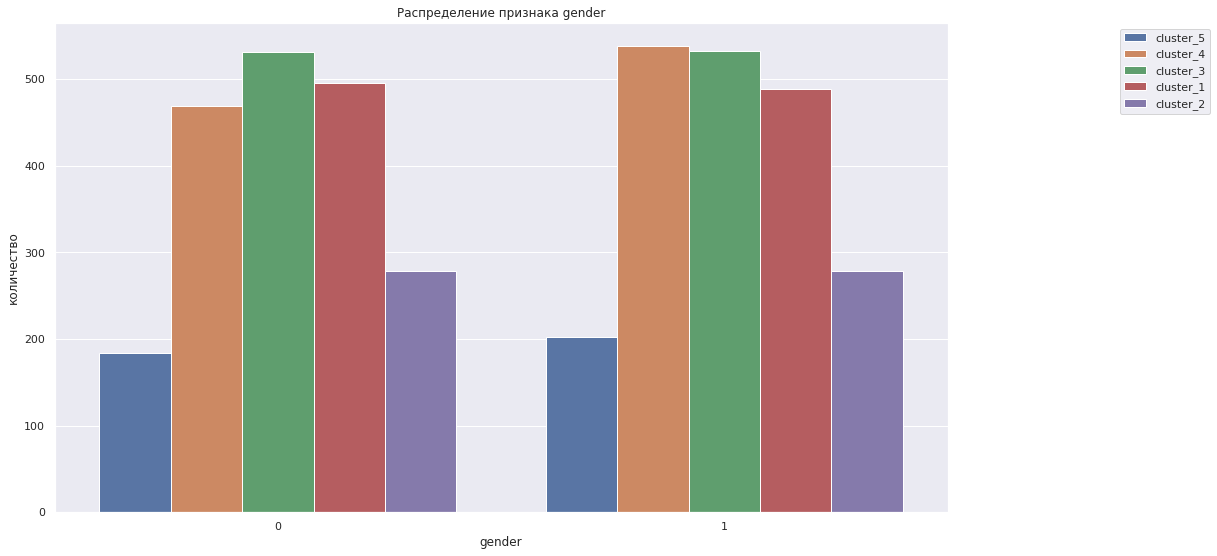

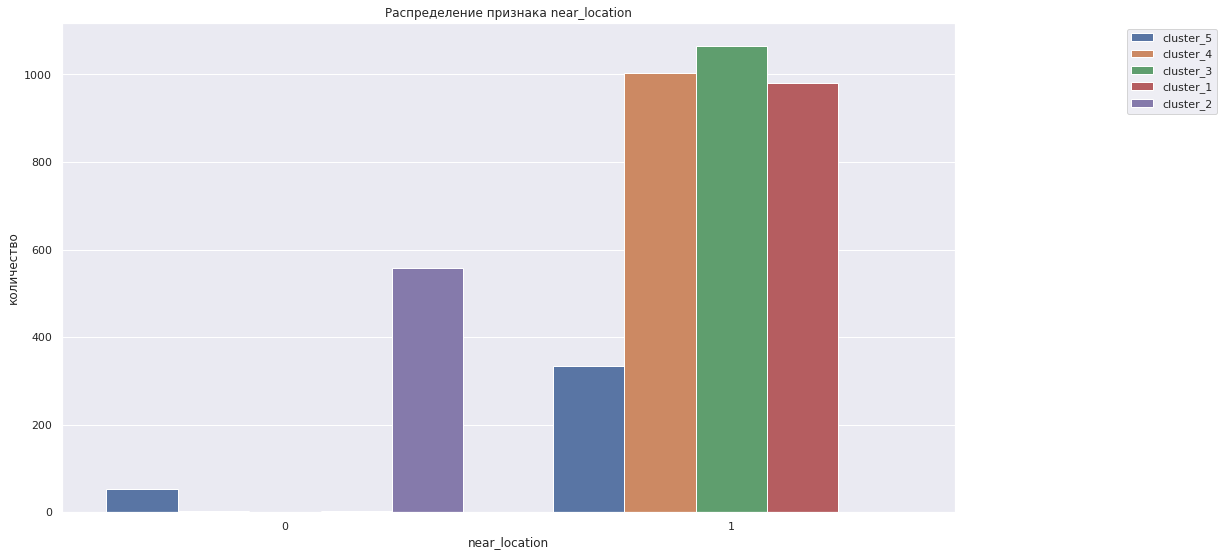

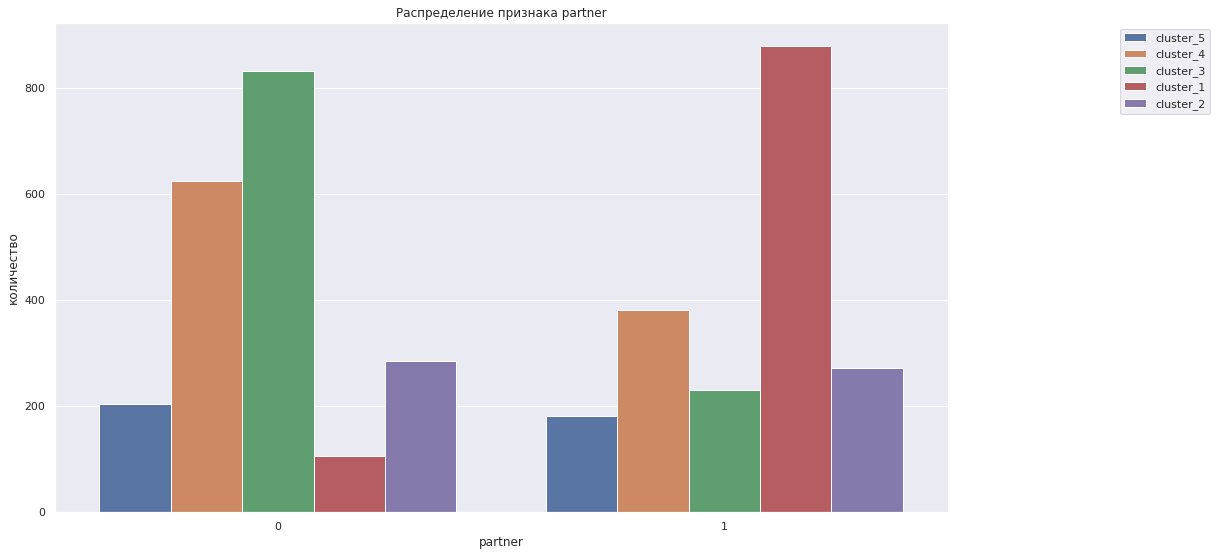

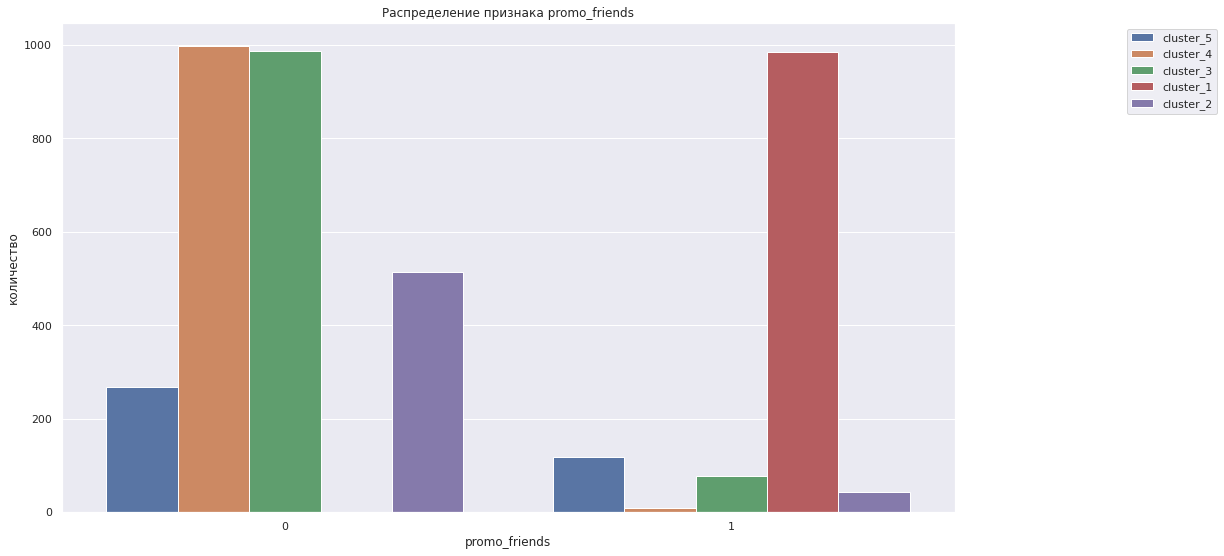

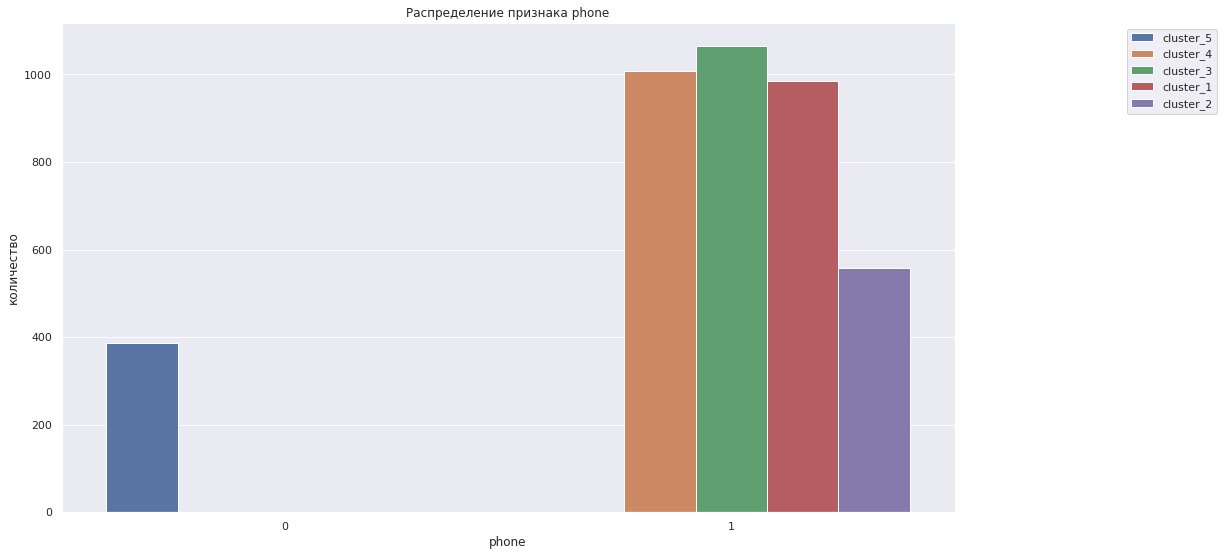

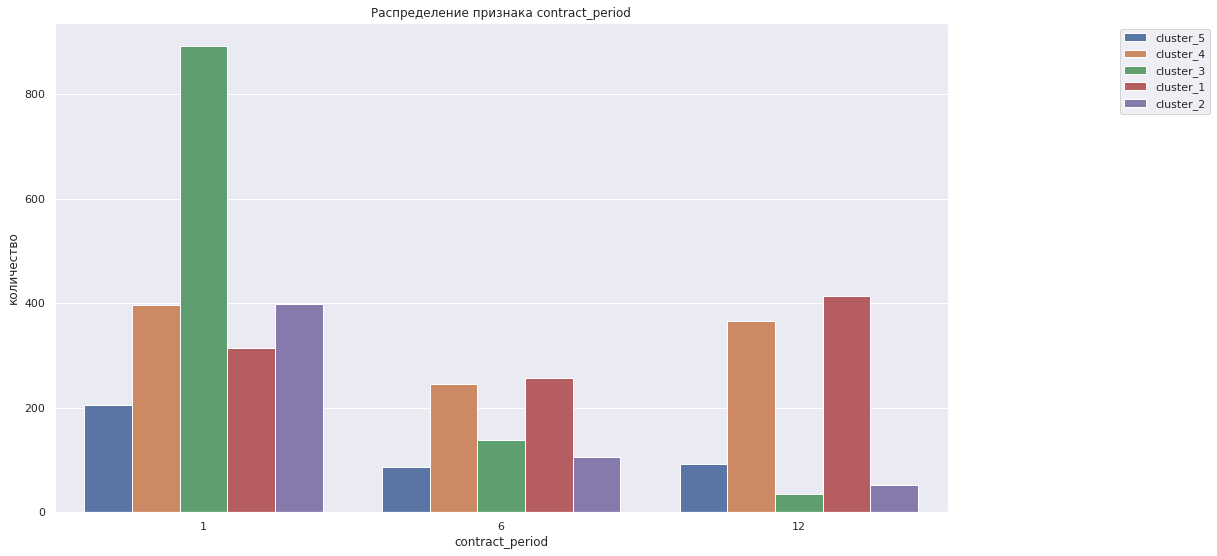

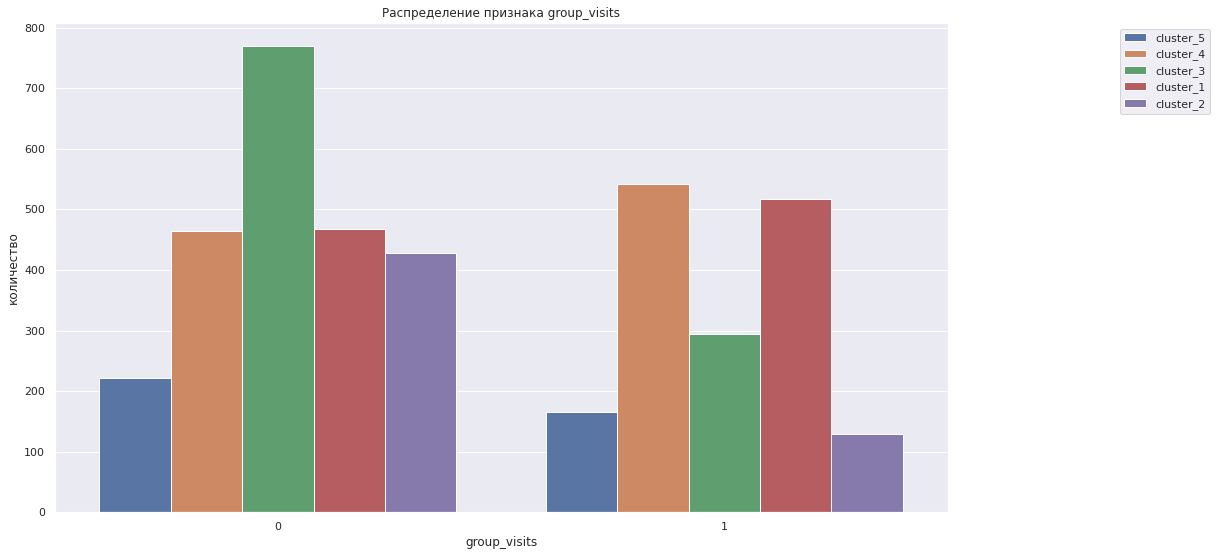

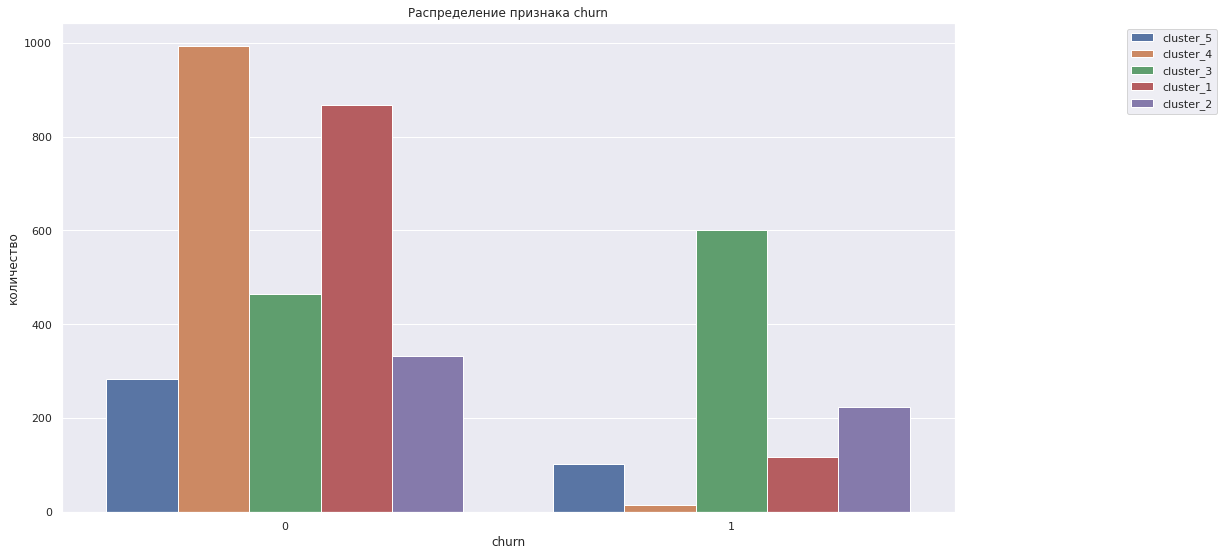

In [53]:
# Построим график для логических и дискретных величин
log_discr_values = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'churn']
fig, ax = plt.subplots()
for column in log_discr_values:
    plt.title("Распределение признака "+column)
    sns.countplot(data=df, x=column, hue='cluster_km')
    plt.xlabel(column)
    plt.ylabel("количество")
    plt.legend(bbox_to_anchor=(1.3, 1))
    plt.show()

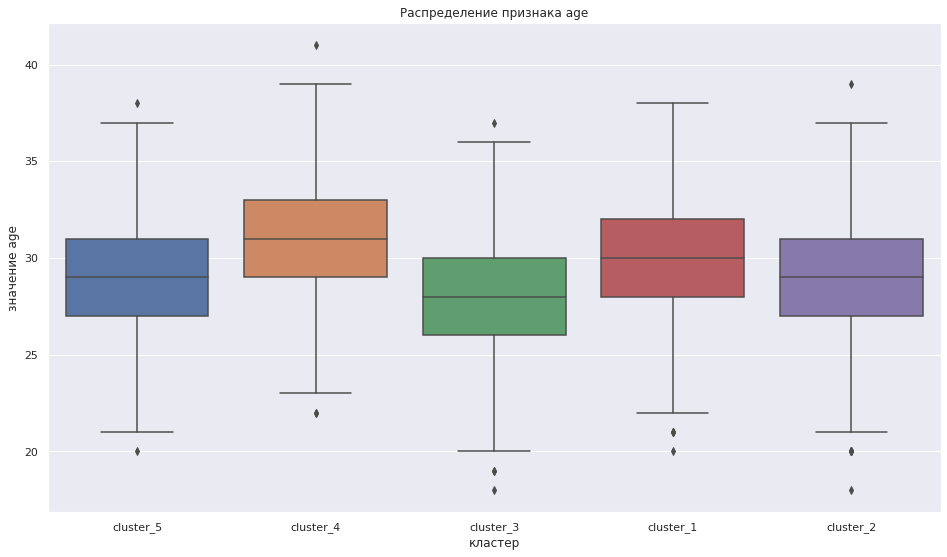

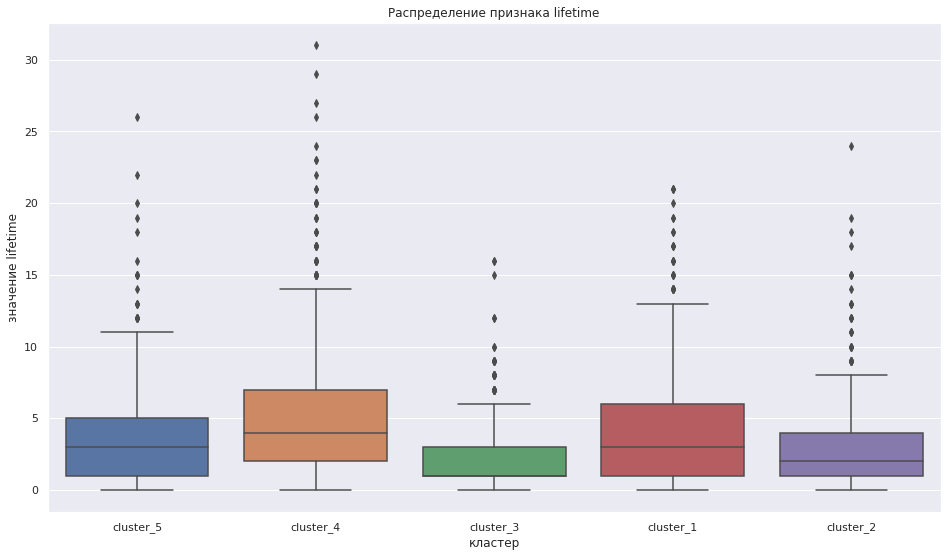

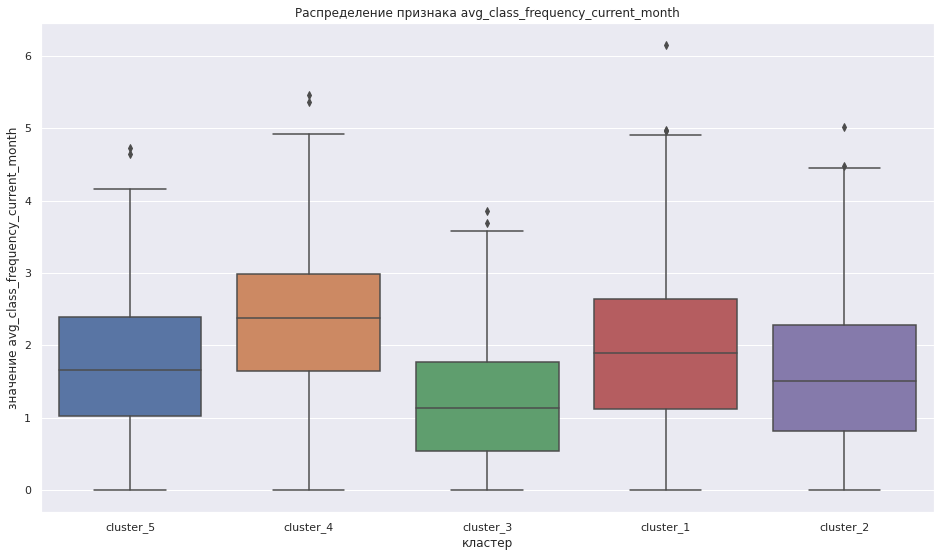

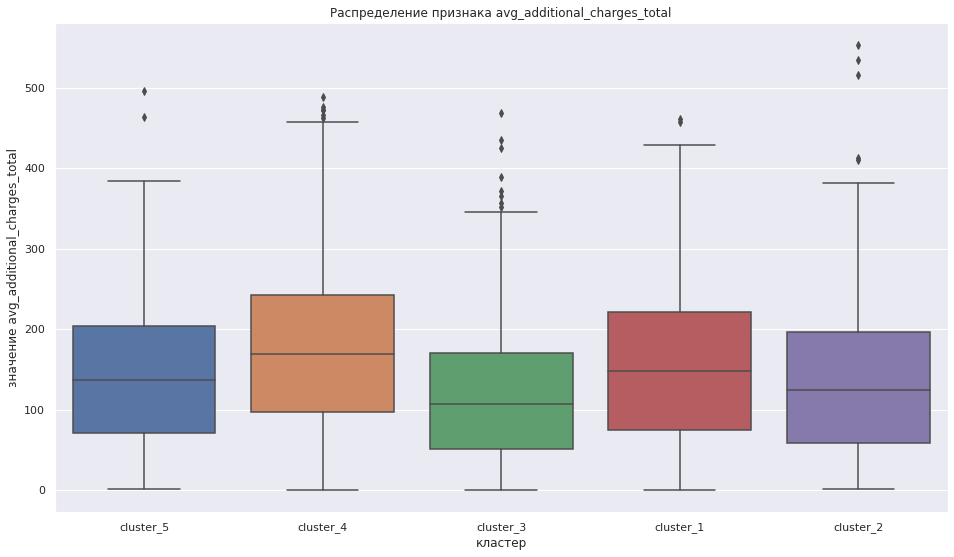

In [54]:
# Построим график для непрерывных величин
cont_values = ['age', 'lifetime', 'avg_class_frequency_current_month', 'avg_additional_charges_total']
fig, ax = plt.subplots()
for column in cont_values:
    plt.title("Распределение признака "+column)
    sns.boxplot(x='cluster_km', y=column, data=df)
    plt.xlabel('кластер')
    plt.ylabel('значение '+column)
    plt.show()

**Кластер 1 характеризуется:**

- приблизительно равным распределением между мужчинами и женщинами;
- клиентами, которые находятся поблизости от фитнес-центра;
- клиентами, большинство из которых (около 80%) пришли не от компаний-партнёров;
- клиентами, которые пришли не по промо-акции от друзей;
- наличием контактных данных;
- абонементом на 1, 6 и 12 месяцев со значительным преобладанием абонементов на 1 месяц;
- клиентами, около 30% которых посещает групповые занятия;
- средним возрастом около 27,5 лет;
- низким уровнем дополнительных оплат;
- коротким сроком от начала пользования услугами;
- посещением около 1 раза в неделю.

**Кластер 2 характеризуется:**

- приблизительно равным распределением между мужчинами и женщинами;
- клиентами, которые находятся поблизости от фитнес-центра;
- клиентами, большинство из которых (около 90%) пришло от компаний-партнёров;
- клиентами, большинство из которых (около 70%) пришло не по промо-акции от друзей;
- наличием контактных данных;
- абонементом на 1, 6 и 12 месяцев с примерно равным распределением и небольшим преобладанием 12 месяцев;
- клиентами, около половины которых посещает групповые занятия;
- средним возрастом около 29,5 лет;
- высоким уровнем дополнительных оплат;
- средним сроком от начала пользования услугами;
- посещением около 2 раз в неделю.

**Кластер 3 характеризуется:**

- приблизительно равным распределением между мужчинами и женщинами;
- клиентами, большинство из которых находится вблизи от фитнес-центра;
- примерно равным числом посетителей от компаний-партнёров и обычных посетителей;
- клиентами, большинство из которых (около 70%) пришло не по промо-акции от друзей;
- отсутствием контактных данных;
- абонементом на 1, 6 и 12 месяцев с примерно равным распределением и небольшим преобладанием 1 месяца;
- клиентами, около 40% которых посещает групповые занятия;
- средним возрастом в 29-29,5 лет;
- средним уровнем дополнительных оплат;
- средним сроком от начала пользования услугами;
- посещением около 1,5-2 раз в неделю.

**Кластер 4 характеризуется:**

- приблизительно равным распределением между мужчинами и женщинами;
- клиентами, живущими или работающими вдали от фитнес-центра;
- примерно равным числом посетителей от компаний-партнёров и обычных посетителей;
- клиентами, большинство из которых (около 75%) пришло не по промо-акции от друзей;
- наличием контактных данных;
- абонементом на 1, 6 и 12 месяцев с преобладанием 1 месяца;
- клиентами, около 25% которых посещает групповые занятия;
- средним возрастом около 28,5 лет;
- средним уровнем дополнительных оплат;
- небольшим сроком от начала пользования услугами;
- посещением около 1,5 раз в неделю.

**Кластер 5 характеризуется:**

- чуть большим числом людей одного пола, по сравнению с другим;
- клиентами, которые находятся вблизи от фитнес-центра;
- клиентами, большинство из которых (около 65%) пришли не от компаний-партнёров;
- клиентами, которые пришли не по промо-акции от друзей;
- наличием контактных данных;
- абонементом на 1, 6 и 12 месяцев с примерно равным распределением и чуть меньшим количеством 6 месяцев;
- клиентами, около половины которых посещает групповые занятия;
- средним возрастом около 30,5 лет;
- очень высоким уровнем дополнительных оплат;
- длительным сроком от начала пользования услугами;
- посещением около 2-2,5 раз в неделю.

### Расчёт и анализ долей оттока для кластеров

In [55]:
# Для каждого полученного кластера посчитаем долю оттока
(df
   .groupby('cluster_km')['churn']
   .mean()
   .reset_index()
   .sort_values(by='churn', ascending=False)
   .reset_index(drop=True))

,cluster_km,churn
0,cluster_3,0.56
1,cluster_2,0.40
2,cluster_5,0.27
3,cluster_1,0.12
4,cluster_4,0.01


Третий кластер более склонен к оттоку: доля около 56%. Второй кластер характеризуется долей оттока в 40%, а пятый - около 27%. Первый и четвёртый кластеры (доля оттока 12% и 1%, соответственно) являются самыми надёжными.

## Выводы и рекомендации по работе с клиентами

**Общий вывод**

Было проведено исследование данных о клиентах фитнес-центра «Культурист-датасаентист». Эти данные содержат в себе информацию о 4 000 клиентов и 14 показателях, один из которых (отток клиентов выбран в модели в качестве результирующего). Анализируемыми показателями, которые влияют на отток выбраны следующие характеристики клиентов: пол, близость к фитнес-центру, принадлежность к компании-партнёру фитнес-центра, факт первоначальной записи в рамках промо-акции «приведи друга», наличие контактного телефона, возраст, время с момента первого обращения в фитнес-центр, длительность текущего действующего абонемента, срок до окончания действующего абонемента, факт посещения групповых занятий, средняя частоа посещений в неделю за все время с начала действия абонемента и за предыдущий месяц, суммарная выручка от других услуг фитнес-центра.

**Анализ данных позволил сделать следующие выводы:**

1. Средняя по оттоку клиентов близка к 0,3, а медиана равна 0.

Соответственно, около трети клиентов фитнес-центра уходит в отток.

2. Средняя по полу клинтов близка к 0,5, а медиана равна 1.

Соответственно, услугами фитнес-центра пользуются в равной степени мужчины и женщины.

3. Средняя по близости к фитнес-центру близка к 0,85, а первый квартиль равен 1. Распределения по признаку не сильно отличаются. Среднее значение для лояльных клиентов чуть выше, чем для людей, уходящих в отток.

Таким образом, фитнес-центр посещает больше клиентов, которые живут поблизости. При этом немного лояльнее к фитнес-центру те, кто живёт поблизости, чем те, кто живёт в отдалении.

4. Средняя по принадлежности к компании-партнёру близка к 0,5. Распределения для ушедших в отток и оставшихся клиентов ведут себя по-разному.

Так, в фитнес-центре в равной степени представлены клиенты, являющиеся сотрудниками компаний-партнёров, и люди, не имеющие к ним отношение. Но ушедшие в отток клиенты в большей степени не являются сотрудниками компаний-партнёров.

5. Средняя по пришедшим по промо-акции "Приведи друга" равна 0,3, медиана равна 0. Распределения для ушедших в отток и лояльных клиентов близки, но средние значения немного отличаются (для второй группы значение выше).

Соответственно, большинство клиентов фитнес-центра не пришло по промо-акции "Приведи друга", но среди лояльных клиентов воспользовавшихся акцией больше, чем среди уходящих в отток.

6. Средняя по наличию контактного телефона близка к 0,9, а четвёртый квартиль равен 1. Распределения по лояльным и нелояльным клиентам имеют схожий вид.

Тамим образом, практически все клиенты фитнес-центра оставляют контакты для связи - вне зависимости от того, останутся они в фитнес-центре, или уйдут в отток.

7. Минимальное значение возраста равно 18, максимальное - 41, среднее - 29. Среднее значение близко к медиане, стандартное отклонение очень низкое, распределение для лояльных и нелояльных клиентов нормальное. Распределение для лояльных клиентов немного смещено вправо со средней в 30, а для ушедших клиентов - влево со средней в 27.

Соответственно, услугами фитнес-центра пользуются клиенты возрастом от 18 до 41 года (со средним возрастом около 29 лет). Причём в отток в дальнейшем уходят клиенты более молодого возраста (около 27 лет).

8. Минимальное значение времени с первого обращения равно 0, максимальное - 31, среднее - 3, медиана близка к 4 месяцам. Распределение времени с момента первого обращения для обоих групп (лояльных и нелояльных) похоже на распределение Пуассона. Но для ушедших в отток клиентов оно сильно смещено влево (со средним в 1 месяц), практически не имея значения в более высоких значениях, а для лояльных клиентов принимает более высокие значения (со средним в 5 месяцев).

Таким образом, в фитнес центре есть "новенькие" клиенты (которые несколько месяцев пользуются услугами центра) и "опытные" клиенты (которые достаточно давно начали посещать фитнес-центр). При этом клиенты, проявляющие уже в первые несколько месяцев лояльность к фитнес-центру, скорее всего, не уйдут в отток в последующие месяцы.

9. Показатель длительности абонемента может принимать значения 1, 6 и 12 месяцев. Среднее значение равно 4-5 месяцев. При этом есть перекос в данных: медиана равна 1 месяцу. Среднее значение для лояльных пользователей - 5-6 месяцев, для уходящих в отток - 1-2 месяца. Показатель времени до окончания абонемента принимает значения от 1 до 12 месяцев. Среднее значение равно 4 месяца, При этом есть перекос в данных: медиана равна 1 месяцу. Различия в распределении групп (лояльных и нелояльных клиентов) по сроку до окончания действующего абонемента такие же, как и в распределениях по длительности абонемента.

Соответственно, клиенты предпочитают покупать абонемент на короткий срок, но купившие более длительный абонемент с большей неохотой уйдут в отток, чем те, у кого он действует короткий срок.

10. Средняя по посещаемости групповых занятий близка к 0,4, а медиана равна 0. Распределения по лояльным и уходящим в отток клиентам различаются.

Так, среди клиентов фитнес-центра больше тех, кто не интересуется групповыми занятиями (около 60%). При этом уходящие в отток клиенты практически не заинтересованы в таких занятиях.

11. Средняя частота посещений за всё время с начала действия абонемента и за предыдущий месяц колеблются в промежутке от 0 до 6 раз в неделю. Среднее значение и медиана практически равны, стандартное отклонение невысоко. Распределение для лояльных и нелояльных групп является нормальным. Для лояльной группы оно немного смещено влево (среднее 1-2), а для группы уходящих в отток имеется сильное смещение влево (среднее около 2).

Соответственно, в фитнес-центре есть люди, которые купили абонемент, но ни разу не посетили центр, а есть и очень "приверженные" клиенты (посещение 6 раз в неделю). При этом, в среднем, все клиенты посещают центр около 1-2 раз в неделю. Однако, среди лояльных клиентов много тех, кто часто посещает фитнес-центр.

12. Выручка с клиента от прочих услуг фитнес-центра сильно колеблется от 0,15 до 552,6 ден.ед. Среднее значение равно 147 ден.ед, а медиана - 136 ден.ед. Между группами (лояльные и нелояльные клиенты) различие в среднем значении составляет 43 ден.ед. (для лояльных значение выше). Распределение средней выручки от других услуг фитнес-центра для обоих датасетов смещено влево с большим смещением для ушедших людей.

Таким образом, затраты на прочие услуги фитнес-центра очень сильно варьируются для клиентов. При этом уходящие в отток клиенты склонны экономить, а среди лояльных клиентов встречаются те, кто готов заплатить очень высокую цену.

13. Основные метрики полученных моделей, построенных алгоритмом логистической регрессии и алгоритмом случайного леса, следующие. Для модели логистической регрессии: Accuracy = 0,92; Precision = 0,85; Recall = 0,84; F1 = 0,84. Для модели случайного леса: Accuracy = 0,91; Precision = 0,85; Recall = 0,77; F1 = 0,81.

Таким образом, и модель логистической регрессии, и модель случайного леса достаточно хорошо способны делать прогноз. Однако, модель логистической регрессии подходит больше по всем показателям: доле правильных ответов (accuracy), точности (precision), полноте (recall), агрерующей метрике F1 и наиболее точной метрике оценки качества классификатора ROC_AUC.

14. По дендрограмме было высказано предположение о наличии четырёх кластеров в данных. Однако, было принято решение для прогноза кластеров клиентов использовать пять кластеров в модели K-Means.

Анализ средних значений и распределений признаков для кластеров показал, что выделенные кластеры имеют следующие отличительные характеристики.

**Кластер 1** - это клиенты, находящиеся поблизости от фитнес-центра, большинство из которых пришло не от компаний-партнёров и не по промо-акции от друзей, с абонементом на 1, 6 и 12 месяцев (со значительным преобладанием первых), для трети из которых групповые занятия важны, с низким уровнем дополнительных оплат, являющиеся нашими "новыми" клиентами, посещающие фитнес-центр около 1 раза в неделю. Для них доля оттока близка к 12% - это один из самых надёжных кластеров. 

**Кластер 2** - это клиенты,находящиеся поблизости от фитнес-центра, большинство из которых пришло от компании-партнёров и не по промо-акции от друзей, с абонементом на 1, 6 и 12 месяцев в примерно равных пропорциях с небольшим преобладанием 12 месяцев, около половины которых посещает групповые занятия, с высоким уровнем дополнительных оплат, некоторое время являющиеся нашими клиентами, посещающие фитнес-центр около 2 раз в неделю. Для них доля оттока близка к 40% - это в очень большой степени склонный к оттоку кластер.

**Кластер 3** - это клиенты, большинство из которых находится вблизи от фитнес-центра, пришедшие примерно в равных пропорциях от компаний-партнёров и не от них, большинство из них пришло не по промо-акции от друзей, без контактных данных, с абонементами на 1, 6 и 12 месяцев (с примерно равным распределением и небольшим преобладанием абонементов на 1 месяц), для большинства из которых (60%) групповые занятия не важны, со средним уровнем дополнительных оплат, некоторое время являющиеся нашими клиентами, посещающие фитнес-центр около 1,5-2 раз в неделю. Для них доля оттока близка к 56% - это наиболее склонный к оттоку кластер.

**Кластер 4** - это клиенты, живущие или работающие вдали от фитнес-центра, пришедшие примерно в равных пропорциях от компаний-партнёров и не от них, большинство из них пришло не по промо-акции от друзей, с абонементами на 1, 6 и 12 месяцев (с преобладанием абонементов на 1 месяц), для большинства из которых групповые занятия не важны, со средним уровнем дополнительных оплат, небольшим сроком от начала пользования услугами, посещающие фитнес-центр около 1,5 раз в неделю. Для них доля оттока близка к 1% - это самый надёжный кластер.

**Кластер 5** - это клиенты с небольшим преобладанием людей одного пола, по сравнению с другим, которые живут или работают возле фитнес-центра, пришедшие в большинстве своём не от компаний-партнёров и не по промо-акции от друзей, с абонементами на 1, 6 и 12 месяцев (с примерно равным распределением 1 и 12 месяцев, и чуть меньшим количеством 6 месяцев), около половины из которых посещает групповые занятия, с очень высоким уровнем дополнительных оплат, являющиеся нашими постоянными "давними" клиентами, посещающие фитнес-центр около 2-2,5 раз в неделю. Для них доля оттока близка к 27%.


**Рекомендации**

На основе представленных выводов, предложены следующие рекомендации для стратегии взаимодействия с пользователями сети фитнес-центров и их удержания:

1. Рекомендуется привлечение в фитнес-центр клиентов из близлежащих спальных районах.

2. Рекомендуется отменить проведение акции "Приведи друга" и акций для сотрудников компаний-партнёров, поскольку они не способствует удержанию клиентов, а высвободившиеся деньги направить на другие мероприятия. Например, раздача листовок в близлежащих районах.

3. Возможно внедрение и реклама абонементов более длительного срока (9 и 12 месяцев) - поскольку чем дольше времени до окончания абонемента, тем лояльнее клиенты.

4. Поскольку категория с длительными абонементами имеет склонность пользоваться доп услугами, для них возможно введение специальных скидок и акций по доп услугам.

5. Рекомендуется установить более выгодные цены на длительные абонементы. Например, цена на абонемент на 3 месяца (нужно внедрить абонементы на 3 месяца) ненамного дороже, чем на абонемент на 1 месяц (чтобы покупатель стремился покупать 3 месяца) - это снизит риски оттока клиентов в первые месяцы.

6. Возможно ввести более выгодное продление абонемента для клиентов, покупающих абонемент сроком от 3 месяцев. Например, по окончании абонемента покупка нового тем же сроком - скидка 25%. Подобные скидки окупятся доп услугами, которыми пользуются лояльные клиенты и отменой неэффективных акций.

7. Рекомендуется проводить мониторинг средней частоты посещений фитнес-центра в неделю по клиентам. При обнаружении снижения показателя предлагать клиентам бонусы - бесплатная разовая доп услуга, скидки на продление абонемента, одно бесплатное групповое занятие по новому для него направлению и т.п.